# VAE

# Dimensionality reduction with Autoencoders versus PCA

In [ ]:
!pip install spectral
!pip install rasterio

     |████████████████████████████████| 212 kB 5.3 MB/s 
     |████████████████████████████████| 19.3 MB 55.1 MB/s 


In [ ]:
# Basic import

from time import time
import rasterio as rio
from sklearn.preprocessing import minmax_scale
from sklearn import cluster
from sklearn.decomposition import PCA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

# generate data
# X, y = datasets.make_classification(n_samples=10000, n_features=50, n_redundant=10, n_informative=10,
                          #  random_state=1, n_clusters_per_class=2,n_classes=3, class_sep=2)
                           
# # divide data in Train - Validation - Test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

# # Standardize Data
# sc = StandardScaler()
# X_tr_std = sc.fit_transform(X_tr)
# X_valid_std = sc.transform(X_valid)
# X_test_std = sc.transform(X_test)

## Load and process Dataset 

In [ ]:
# Importing the data
import rasterio as rio
data_raster = rio.open('drive/MyDrive/VAE_GeoChem/Playa_Image.tif')
data_test   = rio.open('drive/MyDrive/VAE_GeoChem/Playa_Training.tif')
# print(data_raster.meta)

## Visualizing the data
# Reading and enhancing
data_array = data_raster.read() # reading the data
vmin, vmax = np.nanpercentile(data_array, (1,99)) # 5-95% pixel values stretch

data_array_test = data_test.read() # reading the data
vmin, vmax = np.nanpercentile(data_array_test, (1,99)) # 5-95% pixel values stretch
# Plotting the enhanced image
# fig = plt.figure(figsize=[20,20])
# plt.axis('off')
# plt.imshow(data_array[0, :, :], vmin=vmin, vmax=vmax)
# plt.show()

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
## Reshaping the traindata from brc to rcb
# Creating an empty array with the same dimension and data type
imgxyb = np.empty((data_raster.height, data_raster.width, data_raster.count), data_raster.meta['dtype'])
# Looping through the bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = data_raster.read(band+1)

# Reshaping the train data from rcb to samples and features
data_reshaped = imgxyb.reshape(imgxyb.shape[0]*imgxyb.shape[1], -1)
# Scaling
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
data_reshaped.shape

(188788, 7)

In [ ]:
## Reshaping the test data from brc to rcb
# Creating an empty array with the same dimension and data type
imgxyb_test = np.empty((data_test.height, data_test.width, data_test.count), data_test.meta['dtype'])
# Looping through the bands to fill the empty array
for band in range(imgxyb_test.shape[2]):
    imgxyb_test[:,:,band] = data_test.read(band+1)

# Reshaping the test data from rcb to samples and features
data_reshaped_test = imgxyb_test.reshape(imgxyb_test.shape[0]*imgxyb_test.shape[1], -1)
# Scaling
data_reshaped_test = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
data_reshaped_test.shape

(188788, 7)

In [ ]:
# divide data in Train - Validation - Test
X_train, X_test, y_train, y_test = train_test_split(data_reshaped, data_reshaped_test, test_size=0.3, random_state=42)
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

# Standardize Data
sc = StandardScaler()
X_tr_std = sc.fit_transform(X_tr)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)

In [ ]:
print(X_tr_std)

[[-0.56074267 -0.5551958  -0.49172586 ... -0.45462487  0.52632979
   0.58933185]
 [-0.63925998 -0.65082042 -0.69356505 ... -0.76542309 -0.09241598
   0.15213906]
 [ 0.04879964 -0.00394804 -0.16982716 ... -0.5204894  -1.35450596
  -1.509011  ]
 ...
 [ 0.02193845 -0.00582303 -0.08456751 ... -0.21792424  0.20938815
   0.12019386]
 [ 0.24509293  0.1854262   0.09639176 ... -0.02959286  0.51876103
   0.5044489 ]
 [-0.29626329 -0.32269675 -0.36992635 ... -0.35376982  0.12613184
   0.08916139]]


## Let’s set up this AE: 

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(6, input_shape=[7]),
    keras.layers.Dense(5, input_shape=[6]),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(6, input_shape=[5]),
    keras.layers.Dense(7, input_shape=[6]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
    keras.layers.Dense(7, input_shape=[7]),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.01))

history = autoencoder.fit(X_tr_std,X_tr_std, epochs=20,validation_data=(X_valid_std,X_valid_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
                         
codings = encoder.predict(X_tr_std)

Epoch 1/20
3304/3304 [==============================] - 20s 5ms/step - loss: 0.0647 - val_loss: 0.0097
Epoch 2/20
3304/3304 [==============================] - 16s 5ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 3/20
3304/3304 [==============================] - 16s 5ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 4/20
3304/3304 [==============================] - 16s 5ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 5/20
3304/3304 [==============================] - 17s 5ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 6/20
3304/3304 [==============================] - 16s 5ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 7/20
3304/3304 [==============================] - 16s 5ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 8/20
3304/3304 [==============================] - 16s 5ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 9/20
3304/3304 [==============================] - 16s 5ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 10/20
3304/3304 [==============================] - 17s 5ms/step - l

In [ ]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 5)                 419       
                                                                 
 sequential_1 (Sequential)   (None, 7)                 421       
                                                                 
Total params: 840
Trainable params: 840
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.count_params()

840

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [ ]:
print(len(history.history['loss']))
train_loss_val = history.history['loss']
test_loss_val = history.history['val_loss']

20


In [ ]:

train_loss = [i * 1000 for i in train_loss_val]
test_loss  = [i * 1000 for i in test_loss_val]


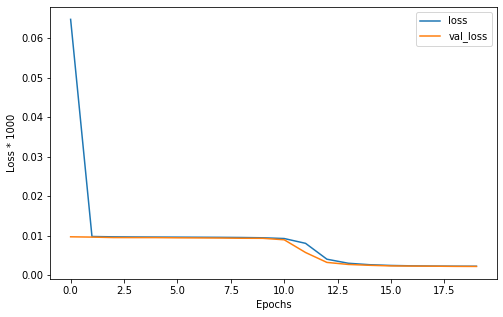

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylabel('Loss * 1000')
plt.xlabel('Epochs')
plt.savefig("summarize history for loss.jpg")

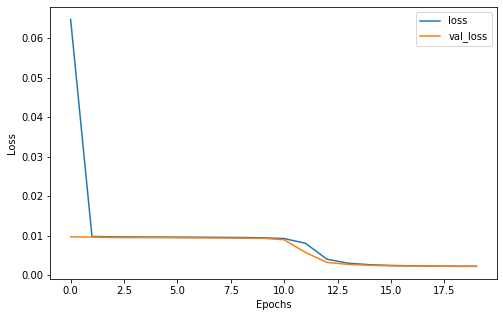

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig("summarize history for loss.jpg")

## PCA implementation:

In [ ]:
from sklearn.decomposition import PCA
# pca = PCA(n_components=5,svd_solver='auto')
# scores = pca.fit_transform(X_tr_std) # u

# PCA
pca = PCA(n_components=data_array.shape[0])
scores = pca.fit_transform(data_reshaped)
var_ratio = pca.explained_variance_ratio_
values = pca.singular_values_

print(var_ratio.shape)
print(values)

(7,)
[186.32807025 118.64892902  17.88859731  10.84392844   3.67100249
   1.82416551   0.85764981]


In [ ]:
# function to plot and display the image
def plot_data(data,fig_name):
  fig = plt.figure(figsize = (15, 10))
  plt.imshow(data, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()
  plt.savefig(fig_name)

# Clustring

# a. PCA -> K-means 

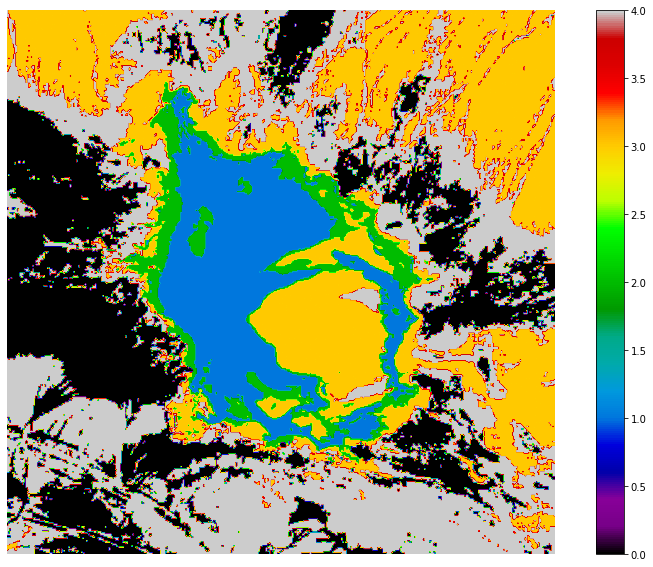

<Figure size 432x288 with 0 Axes>

In [ ]:
# K-means
cl = cluster.KMeans(n_clusters=5) # Creating an object of the classifier
components_num = 5
param = cl.fit(scores[:,:components_num]) # Training
img_c = cl.labels_ # Getting the labels of the classes
img_cl = img_c.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl, 'PCA_k_means.png')

## b. AE -> K-means

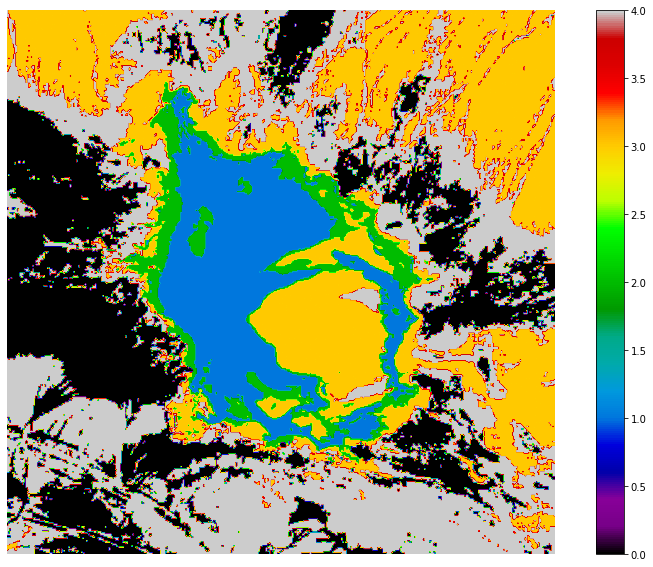

<Figure size 432x288 with 0 Axes>

In [ ]:
# K-means
cl = cluster.KMeans(n_clusters=10) # Creating an object of the classifier
param = cl.fit(codings) # Training
img_c = cl.labels_ # Getting the labels of the classes
# img_cl_pred = cl.predict(data_ae)
img_c2 = img_cl.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_c2, 'AE_k_means.png')

In [ ]:
codings_train = encoder.predict(X_tr_std)
codings_test = encoder.predict(X_test_std)
scores_train = pca.transform(X_tr_std)
scores_test = pca.transform(X_test_std)

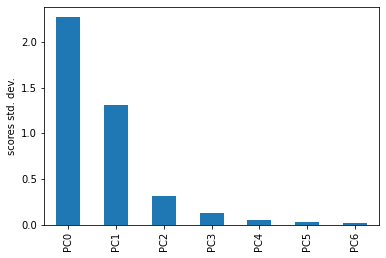

In [ ]:
pd.DataFrame(scores_train, columns=['PC'+str(i) for i in range(pca.n_components_)]).std().plot(kind='bar', color='tab:blue')
plt.ylabel('scores std. dev.')
plt.savefig('scores_std_dev.png')
# plt.savefig("summarize history for loss.jpg")

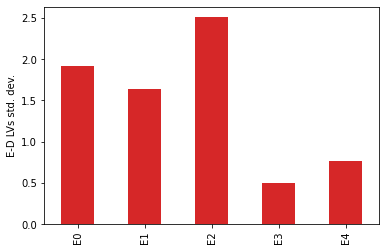

In [ ]:
pd.DataFrame(codings_train, columns=['E'+str(i) for i in range(5)]).std().plot(kind='bar', color='tab:red') # range(no of components)
plt.ylabel('E-D LVs std. dev.')
plt.savefig('E-D_LVs_std_dev.png')

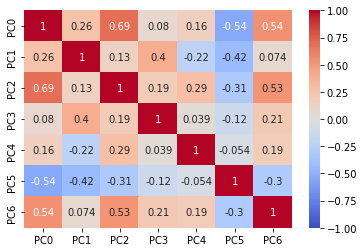

In [ ]:
sns.heatmap(pd.DataFrame(scores_train, columns=['PC'+str(i) for i in range(pca.n_components_)]).corr(), vmin=-1, vmax=+1, cmap='coolwarm', annot=True)

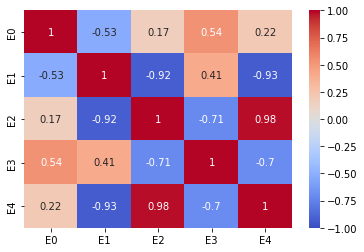

In [ ]:
sns.heatmap(pd.DataFrame(codings_train, columns=['E'+str(i) for i in range(5)]).corr(), vmin=-1, vmax=+1, cmap='coolwarm', annot=True)

In [ ]:
autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 5)                 195       
                                                                 
 sequential_7 (Sequential)   (None, 7)                 197       
                                                                 
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________


## NonLinear Stacked Encoder-Decoder
The nonlinear stacked AE will be easily implemented as the stacked AE but with an activation function. We also introduced a decay constant over the SGD optimizer so that the learning rate will decrease over time. We pick “selu” as activation layer for all layers. Note that here we have increased the complexity even more: we could try to find the best number of hidden layers, the best activation function and shape of each of the layers for the specific problem.

In [ ]:
nl_st_encoder = keras.models.Sequential([
    keras.layers.Dense(6, input_shape=[7], activation='relu'),
    keras.layers.Dense(5, activation='selu'),
    keras.layers.Dense(5, activation='selu'),
])

nl_st_decoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[5], activation='selu'),
    keras.layers.Dense(6, activation='selu'),
    keras.layers.Dense(7, activation='relu'),
])

nl_st_autoencoder = keras.models.Sequential([nl_st_encoder, nl_st_decoder])
nl_st_autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4))
nl_st_autoencoder.summary()


history = nl_st_autoencoder.fit(X_tr_std,X_tr_std, epochs=10,validation_data=(X_valid_std,X_valid_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)],verbose=1)

nl_st_codings_train = nl_st_encoder.predict(X_tr_std)
nl_st_codings_test = nl_st_encoder.predict(X_test_std)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 5)                 113       
                                                                 
 sequential_4 (Sequential)   (None, 7)                 115       
                                                                 
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.5191 - val_loss: 0.5053
Epoch 2/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.4975 - val_loss: 0.5039
Epoch 3/10
3304/3304 [==============================] - 5s 2ms/step - loss: 0.4967 - val_loss: 0.5034
Epoch 4/10
3304/3304 [==============================] - 5s 2ms/step - loss: 0.4963 - val_loss: 0.5031
Epoch 5/10
3304/3304 [======================

# Conclusion 
Our aim was to compare PCA and an AutoEncoder neural network to see if the dimensionality reduction was comparable.

- We looked at the properties of the scores/encodings and we saw that encodings from the AE have some correlations (the covariant matrix is not diagonal like in PCA), and also that their standard deviation is similar.
Starting from a simple linear undercomplete AE with just 1 layer, we saw that increasing complexity helped the model reach better performances, evaluated in terms of classification accuracy.
- Finally, we saw that a non linear model can still perform better than the other two (one layer AE and stacked AE) but the performance is still comparable to that of PCA in this dataset.

https://github.com/rasbt/deeplearning-models/tree/master/pytorch_ipynb/autoencoder

# VAE 

In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(7, 6)
        self.linear2 = nn.Linear(5, latent_dims)
        self.linear3 = nn.Linear(5, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(5, 6)
        self.linear2 = nn.Linear(6, 7)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

In [ ]:
# mnist_vae_viz.py

# PyTorch variational autoencoder for MNIST visualization
# compress each 28x28 MNIST digit to 2 values then plot

# use custom generated text MNIST rather than
# the built-in torchvision MNIST

# PyTorch 1.8.0-CPU Anaconda3-2020.02  Python 3.7.6
# CPU, Windows 10

import numpy as np
import torch as T
import matplotlib.pyplot as plt
import torchvision as tv  # to visualize fakes

device = T.device("gpu")

# -----------------------------------------------------------

class dataset_playa():
  # for an Autoencoder (not a classifier)
  # assumes data has been converted to tab-delim text files:
  # 7 pixel values (0-255) (tab) label (0-9)
  # [0] [1] . . [7] [7] 

  def __init__(self, tmp_x,tmp_y):
    # tmp_x = np.loadtxt(src_file, usecols=[784],
    #   deliminp.loadtxt(src_file, usecols=range(0,7),
    #   delimiter="\t", comments="#", dtype=np.float32)
    # tmp_y = ter="\t", comments="#", dtype=np.int64)
    self.x_data = T.tensor(tmp_x, dtype=T.float32).to(device) 
    # self.x_data /= 255.0  # normalize pixels
    self.y_data = T.tensor(tmp_y, dtype=T.int64).to(device)
    # don't normalize digit labels

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    pixels = self.x_data[idx]
    label = self.y_data[idx]
    return (pixels, label)

# -----------------------------------------------------------
# for the dataset (after reshaping the data)

# def dataset_playa(temp_x,tmp_y):
#   
#   x_data = T.tensor(tmp_x, dtype=T.float32).to(device) 
#   x_data /= 255.0  # normalize pixels
#   y_data = T.tensor(temp_y, dtype=T.int64).to(device)
#   return pixels, label

# -----------------------------------------------------------

class VAE(T.nn.Module):  # [7-6-5-[2,2]-2-5-6-7]
  def __init__(self):
    super(VAE, self).__init__()  
    self.fc1a = T.nn.Linear(7, 6)  # no labels
    self.fc1b = T.nn.Linear(6, 5)  # no labels

    self.fc2a = T.nn.Linear(5, 2)   # u
    self.fc2b = T.nn.Linear(5,2)   # log-var


    self.fc3 = T.nn.Linear(2, 5)
    self.fc4a = T.nn.Linear(5, 6) 
    self.fc4b  = T.nn.Linear(6, 7)

  def encode(self, x):              # 7-6-5-[2,2]  
    z = T.relu(self.fc1a(x)) 
    z = T.relu(self.fc1b(z))
    z1 = self.fc2a(z)               # activation here ??
    z2 = self.fc2b(z) 
    return (z1, z2)                 # (u, log-var)

  def decode(self, x):              # 2-5-6-7
    z = T.relu(self.fc3(x))
    z = T.relu(self.fc4a(z))     
    z = T.sigmoid(self.fc4b(z))      # in [0, 1]
    return z 

  def forward(self, x):
    (u, logvar) = self.encode(x)
    stdev = T.exp(0.5 * logvar)
    noise = T.randn_like(stdev)
    z = u + (noise * stdev)         # [2]
    oupt = self.decode(z)
    return (oupt, u, logvar)

# -----------------------------------------------------------

def cus_loss_func(recon_x, x, u, logvar):
  # https://arxiv.org/abs/1312.6114
  # KLD = 0.5 * sum(1 + log(sigma^2) - u^2 - sigma^2)
  # bce = T.nn.functional.binary_cross_entropy(recon_x, \
  #   x.view(-1, 784), reduction="sum")

  # mse = T.nn.functional.mse_loss(recon_x, x.view(-1, 784))
  mse = T.nn.functional.mse_loss(recon_x, x)

  kld = -0.5 * T.sum(1 + logvar - u.pow(2) - \
    logvar.exp())

  BETA = 1.0
  return mse + (BETA * kld)

# -----------------------------------------------------------

def train(vae, ds, bs, me, lr, le):
  # train autoencoder vae with dataset ds using batch size bs, 
  # with max epochs me, learn rate lr, log_every le
  data_ldr = T.utils.data.DataLoader(ds, batch_size=bs,
    shuffle=True)
  
  # loss_func = T.nn.MSELoss() # use custom loss
  opt = T.optim.SGD(vae.parameters(), lr=lr)
  # print(vae.parameters())
  print("Starting training")
  for epoch in range(0, me):
    for (b_idx, batch) in enumerate(data_ldr):
      opt.zero_grad()
      X = batch[0]  # don't use Y labels to train
      recon_x, u, logvar = vae(X)
      loss_val = cus_loss_func(recon_x, X, u, logvar)
      loss_val.backward()
      opt.step()

    if epoch != 0 and epoch % le == 0:
      print("epoch = %6d" % epoch, end="")
      print("  curr batch loss = %7.4f" % loss_val.item(), end="")
      print("")

      # save and view sample images as sanity check
      # num_images = 64
      # rinpt = T.randn(num_images, 2).to(device)
      # with T.no_grad():
      #   fakes = vae.decode(rinpt)
      # fakes = fakes.view(num_images, 1, 28, 28)
      # tv.utils.save_image(fakes,
      #   ".\\Fakes\\fakes_" + str(epoch) + ".jpg",
      #   padding=4, pad_value=1.0) # no overwrite

  print("Training complete ")

# -----------------------------------------------------------
# divide data in Train - Validation - Test
# X_train, X_test, y_train, y_test = train_test_split(data_reshaped, data_reshaped_test, test_size=0.3, random_state=42)
# X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 


# -----------------------------------------------------------
def main():
  # 0. get started
  print("\nBegin VAE  ")
  T.manual_seed(1)
  np.random.seed(1)

  # 1. create Dataset object
  print("\nCreating  Dataset ")
  # fn = ".\\Data\\mnist_train_10000.txt"
  # data_ds = MNIST_Dataset(fn)           ############################################ reshaped dataset here.    #############
  data_ds = dataset_playa(X_train,y_train)
  # print(data_ds.shape)
  # 2. create and train VAE model 
  print("\nCreating VAE  \n")
  vae = VAE()   # 7-5-[2,2]-2-5-7
  vae.train()           # set mode

  # Hyperparameters
  bat_size = 10000
  max_epochs = 40
  lrn_rate = 0.1
  log_every = int(max_epochs / 10)
  train(vae, data_ds, bat_size, max_epochs, \
    lrn_rate, log_every)

  # 3. TODO: save trained VAE

  # 4. use model encoder to generate (x,y) pairs
  vae.eval()
  all_pixels = data_ds[0:1000][0]  # all pixel values
  all_labels = data_ds[0:1000][1]

  with T.no_grad():
    u, logvar = vae.encode(all_pixels) # mean logvar

  print("\nImages reduced to 2 values: ")
  print(u)

  # 5. graph the reduced-form digits in 2D
  # print("\nPlotting reduced-dim images")
  # plt.scatter(u[:,0], u[:,1],
  #           c=all_labels, edgecolor='none', alpha=0.9,
  #           cmap=plt.cm.get_cmap('nipy_spectral', 11),
  #           s=20)  # s=20 orig, alpha=0.9
  # plt.xlabel('mean[0]')
  # plt.ylabel('mean[1]')
  # plt.colorbar()
  # plt.show()
  # plt.savefig()

  print("\nEnd VAE")

# -----------------------------------------------------------

if __name__ == "__main__":
  main()


Begin VAE  

Creating  Dataset 

Creating VAE  

Starting training
epoch =      4  curr batch loss =     nan
epoch =      8  curr batch loss =     nan
epoch =     12  curr batch loss =     nan
epoch =     16  curr batch loss =     nan
epoch =     20  curr batch loss =     nan
epoch =     24  curr batch loss =     nan
epoch =     28  curr batch loss =     nan
epoch =     32  curr batch loss =     nan
epoch =     36  curr batch loss =     nan
Training complete 

Images reduced to 2 values: 
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]])

End VAE


In [ ]:
VAE.summary()

AttributeError: ignored